In [20]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import StratifiedKFold, train_test_split
from imblearn.over_sampling import SMOTE
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from torchmetrics.classification import MulticlassF1Score, MulticlassAccuracy, MulticlassPrecision, MulticlassRecall
from itertools import zip_longest
import thesis_models

In [21]:
#Define File Path
bert_path = "./vec_data/twc_news_vec.npz"
le_stance_labels = "./vec_data/le_stance_labels.npz"

In [22]:
def load_npz_file(filepath):
    # Load the numpy array from the .npz file
    with np.load(filepath, allow_pickle=True) as data:
        for key in data.keys():
            arr = data[key]
            break
    return arr

In [23]:
bert_vec = load_npz_file(bert_path)
le_label = load_npz_file(le_stance_labels)

In [24]:
#指派實際要使用的Data與Label
data = bert_vec
label = le_label

In [25]:
print(data.shape)
print(label.shape)
print(np.unique(label))
print(np.unique(label, return_counts=True))

(445, 768)
(445,)
[0 1 2 3]
(array([0, 1, 2, 3]), array([ 11, 201,  74, 159], dtype=int64))


In [26]:
# Data Augmentation using Oversampling
# Define the oversampling ratio for each class
# oversample_ratio = {0: 100, 1: 201, 2: 120, 3: 159}
oversample_ratio = {0: 150, 1: 201, 2: 175, 3: 183}
# Initialize the oversampler
oversampler = SMOTE(sampling_strategy=oversample_ratio)
# Reshape your data to a 2D matrix of shape (n_samples, n_features)
X = data.reshape(-1, 768)
# Apply oversampling to X and y
X_resampled, y_resampled = oversampler.fit_resample(X, label)
# Reshape X back to its original shape
X_resampled = X_resampled.reshape(-1, 1, 768)

In [27]:
print(X_resampled.shape)
print(y_resampled.shape)

(709, 1, 768)
(709,)


In [28]:
X_data, test_data, X_labels, test_labels = train_test_split(X_resampled, y_resampled, stratify=y_resampled, test_size=0.1)

In [29]:
print('Train data shape:', X_data.shape)
print('Train labels shape:', X_labels.shape)
print('Test data shape:', test_data.shape)
print('Test labels shape:', test_labels.shape)

Train data shape: (638, 1, 768)
Train labels shape: (638,)
Test data shape: (71, 1, 768)
Test labels shape: (71,)


In [30]:
X_tensor = torch.from_numpy(X_data).float()
y_tensor = torch.from_numpy(X_labels).long()
test_data_tensor = torch.from_numpy(test_data).float()
test_labels_tensor = torch.from_numpy(test_labels).long()
test_dataset = TensorDataset(test_data_tensor, test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [31]:
# Trainging Settings
input_size = 768  # Size of input vector
hidden_size = 256  # Number of features in the hidden state
num_layers = 2  # Number of LSTM layers
output_size = 4  # Number of output classes
learning_rate = 0.0008
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Epochs and records
num_epochs = 30
train_losses_list = []
val_losses_list = []
train_accuracies_list = []
val_accuracies_list = []

# # torchmetrcis settings
model_accuracy = MulticlassAccuracy(num_classes=4, average='macro').to(device)
model_precision = MulticlassPrecision(num_classes=4, average='macro').to(device)
model_recall = MulticlassRecall(num_classes=4, average='macro').to(device)
model_f1 = MulticlassF1Score(num_classes=4, average='macro').to(device)

# Define the number of folds for k-fold cross-validation
num_folds = 5
# Initialize the k-fold cross-validator
skf = StratifiedKFold(n_splits=num_folds, shuffle=True)

In [32]:
for fold, (train_idx, val_idx) in enumerate(skf.split(X_tensor, y_tensor)):
    print(f'Fold {fold + 1}')
    X_train_fold = X_tensor[train_idx]
    y_train_fold = y_tensor[train_idx]
    X_val_fold = X_tensor[val_idx]
    y_val_fold = y_tensor[val_idx]

    # Create PyTorch DataLoader for training and validation
    train_data = TensorDataset(X_train_fold, y_train_fold)
    val_data = TensorDataset(X_val_fold, y_val_fold)
    train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=16, shuffle=False)

    # Initialize the reocrd lists for this fold
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Early Stopping Settings
    patience = 3
    counter = 0
    best_val_accuracy = 0.0

    # Instantiate the model
    model = thesis_models.LSTM_2(input_size, hidden_size, num_layers, output_size, True)
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
      model.train()
      train_loss = 0.0
      train_correct = 0
      for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        train_correct += (predicted == target.squeeze().long()).sum().item()
      train_loss /= len(train_loader)
      train_accuracy = 100.0 * train_correct / len(train_data)
      train_losses.append(train_loss)
      train_accuracies.append(train_accuracy)

      # Evaluate the model on the validation set
      model.eval()
      val_loss = 0.0
      val_correct = 0
      with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
          data = data.to(device)
          target = target.to(device)
          output = model(data)
          loss = criterion(output, target)
          val_loss += loss.item()
          _, predicted = torch.max(output.data, 1)
          val_correct += (predicted == target.squeeze().long()).sum().item()
      val_loss /= len(val_loader)
      val_accuracy = 100.0 * val_correct / len(val_data)
      val_losses.append(val_loss)
      val_accuracies.append(val_accuracy)

      print('Epoch: {} \tTrain Loss: {:.6f} \tTrain Accuracy: {:.2f}% \tVal Loss: {:.6f} \tVal Accuracy: {:.2f}%'.format(
          epoch, train_loss, train_accuracy, val_loss, val_accuracy))
      
      if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        counter = 0
      else:
        counter += 1
        if counter >= patience:
          print("Early stopping at epoch", epoch)
          break
        
    # Append the lists for this fold to the corresponding list for all folds
    train_losses_list.append(train_losses)
    val_losses_list.append(val_losses)
    train_accuracies_list.append(train_accuracies)
    val_accuracies_list.append(val_accuracies)

Fold 1
Epoch: 0 	Train Loss: 1.393716 	Train Accuracy: 22.35% 	Val Loss: 1.378500 	Val Accuracy: 23.44%
Epoch: 1 	Train Loss: 1.376341 	Train Accuracy: 27.45% 	Val Loss: 1.353130 	Val Accuracy: 36.72%
Epoch: 2 	Train Loss: 1.281865 	Train Accuracy: 35.49% 	Val Loss: 1.145930 	Val Accuracy: 40.62%
Epoch: 3 	Train Loss: 1.177461 	Train Accuracy: 40.78% 	Val Loss: 1.100325 	Val Accuracy: 43.75%
Epoch: 4 	Train Loss: 1.141998 	Train Accuracy: 39.22% 	Val Loss: 1.085629 	Val Accuracy: 41.41%
Epoch: 5 	Train Loss: 1.073361 	Train Accuracy: 46.08% 	Val Loss: 0.999893 	Val Accuracy: 43.75%
Epoch: 6 	Train Loss: 0.998673 	Train Accuracy: 48.04% 	Val Loss: 1.000999 	Val Accuracy: 42.97%
Early stopping at epoch 6
Fold 2
Epoch: 0 	Train Loss: 1.387118 	Train Accuracy: 27.65% 	Val Loss: 1.372234 	Val Accuracy: 33.59%
Epoch: 1 	Train Loss: 1.363146 	Train Accuracy: 29.80% 	Val Loss: 1.334786 	Val Accuracy: 32.03%
Epoch: 2 	Train Loss: 1.241289 	Train Accuracy: 40.00% 	Val Loss: 1.110443 	Val Accurac

In [33]:
avg_train_losses = [sum(filter(lambda x: x is not None, items))/len(list(filter(lambda x: x is not None, items))) for items in zip_longest(*train_losses_list)]
avg_val_losses = [sum(filter(lambda x: x is not None, items))/len(list(filter(lambda x: x is not None, items))) for items in zip_longest(*val_losses_list)]
avg_train_accuracies = [sum(filter(lambda x: x is not None, items))/len(list(filter(lambda x: x is not None, items))) for items in zip_longest(*train_accuracies_list)]
avg_val_accuracies = [sum(filter(lambda x: x is not None, items))/len(list(filter(lambda x: x is not None, items))) for items in zip_longest(*val_accuracies_list)]

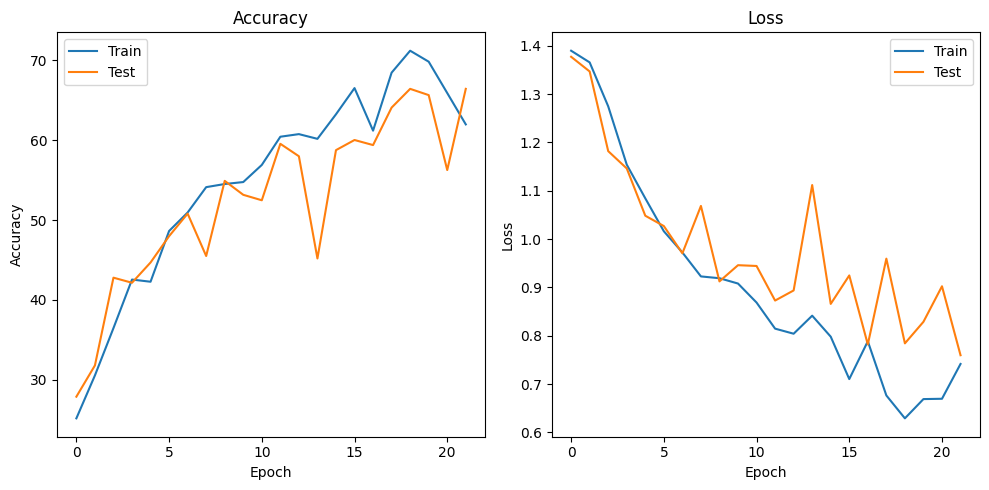

In [34]:
# Plot the train and test accuracy and loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(avg_train_accuracies, label='Train')
ax1.plot(avg_val_accuracies, label='Test')
ax1.set_title('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(avg_train_losses, label='Train')
ax2.plot(avg_val_losses, label='Test')
ax2.set_title('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
# plt.savefig('./Traininglog_pic/lexp_vec20_sum_LSTM2_230505.PNG', dpi=300)
plt.show()

In [35]:
# 測試模型
model.eval()
test_correct = 0
model_accuracy.reset()
model_precision.reset()
model_recall.reset()
model_f1.reset()

with torch.no_grad():
  for batch_idx, (data, target) in enumerate(test_loader):
    data = data.to(device)
    target = target.to(device)
    output = model(data)
    _, predicted = torch.max(output.data, 1)
    model_accuracy(predicted, target.squeeze().long())
    model_precision(predicted, target.squeeze().long())
    model_recall(predicted, target.squeeze().long())
    model_f1(predicted, target.squeeze().long())
print(f"Test Accuracy: {model_accuracy.compute():.4f}")
print(f"Test Precision: {model_precision.compute():.4f}")
print(f"Test Recall: {model_recall.compute():.4f}")
print(f"Test F1-score: {model_f1.compute():.4f}")

Test Accuracy: 0.6569
Test Precision: 0.6883
Test Recall: 0.6569
Test F1-score: 0.6682


In [36]:
# #Save Model Parameter
# torch.save(model.state_dict(), './models/lexp_LSTM2_vec20sum_90p_weight.pt')

In [37]:
# del model